In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.figure import Figure
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import re
import time
import random
import imageio
import glob
from numpy import array
import librosa
musicTrainDataPath = 'drive/MyDrive/Data/speech_music_classification/train/music'
speechTrainDataPath = 'drive/MyDrive/Data/speech_music_classification/train/speech'
musicTrainData = glob.glob(musicTrainDataPath+ '/*.wav')
speechTrainData = glob.glob(speechTrainDataPath+ '/*.wav')

K = 64
N = 400
F = np.zeros((K,N), np.complex64)
for k in range(K):
    for n in range(N):
        F[k,n] =  np.exp(-2j *k * n * np.pi/N)

def spectrogramFeatureGeneration(x):
    windowLength=400
    hopLength=160
    n_fft=256
    numberOfFrames = 1 + np.int(np.floor((len(x) - windowLength) / float(hopLength)))
    xf = np.zeros((numberOfFrames, K), np.complex64)
    for i in range(numberOfFrames):
      z = x[i * hopLength: i * hopLength + windowLength] * np.hamming(windowLength)
      z2 = F @ z    
      xf[i] = z2
    xf = np.log(np.abs(xf[:, :K // 2])+1e-8)                     
    return xf

musicFrames = [] 
for i in range(0, len(musicTrainData)):
  data, sampleRate = librosa.load(musicTrainData[i],sr = None) 
  musicFrames.extend(spectrogramFeatureGeneration(data))
musicFrames = np.array(musicFrames)
musicFrames.shape

speechFrames = []
for i in range(0, len(speechTrainData)):
  data, sampleRate = librosa.load(speechTrainData[i],sr = None)
  speechFrames.extend(spectrogramFeatureGeneration(data))
speechFrames = np.array(speechFrames)
speechFrames.shape

class kMeanClustering:
#Constructor for KMean clustering class
  def __init__(self, clusterCount = 2, numberOfIteration = 200):
    self.clusterCount = clusterCount
    self.numberOfIteration = numberOfIteration
    self.centers = None  

#Making K-mean clusters 
  def kMeanClusteringfit(self, musicFrames):
    no_of_iteration=0
#Taking random points from feature vector as initial K centers for K means 
    self.centers = musicFrames[np.random.choice(np.arange(len(musicFrames)), size = self.clusterCount)]

#Going till maximum of 200 iterations for K means convergence 
    for _ in range(self.numberOfIteration):
      no_of_iteration+=1
      distanceMatrix = np.zeros((len(musicFrames), self.clusterCount))
      for i in  range(self.clusterCount):
        distanceMatrix[:, i] = self.featureDistance(musicFrames, self.centers[i]) 
      clusterAssignment = distanceMatrix.argmin(axis=1)
      newCenters = np.zeros_like(self.centers)
      for i in range(self.clusterCount):
        newCenters[i] = np.mean(musicFrames[clusterAssignment == i], axis=0)
#If (rtol=1e-05, atol=1e-08) tolerance is within this range we stop K-means algorithm
      if np.allclose(newCenters, self.centers):
        self.centers = newCenters
        break
      self.centers = newCenters
    print(no_of_iteration)
    return self.centers
    print(no_of_iteration)

#for finding distance from cluster center for each feature point          
  def kMeanClusteringpredict(self, musicFrames):
    distanceMatrix = np.zeros((len(musicFrames), self.clusterCount)) 
    for i in range(self.clusterCount):
      distanceMatrix[:, i] = self.featureDistance(musicFrames, self.centers[i]) 
    clusterAssignment = distanceMatrix.argmin(axis=1)
    return clusterAssignment

#Calculating eucledian distance
  def featureDistance(self, A, B):
    diff = A - B
    sum = np.sum((A - B) ** 2,axis=1)
    dist = np.sqrt(sum)
    return dist

class gaussian:

#Constructor for Gaussian Mixture Model
  def __init__(self, numberOfMixtures, clusters = None, totalIterations = 1000, covarianceFlag = True):
    self.numberOfMixtures = numberOfMixtures
    self.totalIterations = totalIterations
    self.logLikeliHoodList = []
    self.covarianceFlag = covarianceFlag
    if clusters == None:
      self.clusters = [f"cluster{index}" for index in range(self.numberOfMixtures)]
    else:
      self.clusters = clusters
    self.alpha = np.ones(numberOfMixtures) / numberOfMixtures

  def logLikelihood(self, musicFrames):
    # alpha = np.ones(numberOfMixtures) / numberOfMixtures
    p = np.zeros((len(musicFrames), self.numberOfMixtures))
#Calculating P(xi/theta) for all the gaussian of mixture
    for i in range(self.numberOfMixtures):
      p[:, i] = self.alpha[i] * multivariate_normal(self.mean_val[i], self.covariance[i]).pdf(musicFrames)
      # probs[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
      # p.append([multivariate_normal(mean_val[k], covariance[k]).pdf(musicFrames[n]) for k in range(numberOfMixtures)])
    likeliHood = np.sum(np.log(p.sum(axis=1)))
    return likeliHood


  def gaussianfit(self, musicFrames):
#Taking the number of clusters to be the number of gaussians in GMM
    kMeanClusteringObject = kMeanClustering(self.numberOfMixtures)
#Training GMM model with K-means initialization
    self.mean_val = kMeanClusteringObject.kMeanClusteringfit(musicFrames)
    self.covariance = np.zeros((self.numberOfMixtures, musicFrames.shape[1], musicFrames.shape[1]))
#Using the k-means cluster made above to assign points to respective cluster
    predictionkMeanClustering = kMeanClusteringObject.kMeanClusteringpredict(musicFrames)
#For each gaussian of GMM mixture we are calculating covariance for 1-1 Kmean cluster component 
    for i in range(self.numberOfMixtures):
      self.covariance[i] = np.cov(musicFrames[predictionkMeanClustering == i].T)
#----------------   E - STEP   ------------------ '''
#Posteriour probability of choosing a perticular gaussian 

    for _ in range(self.totalIterations):
      self.temp = np.zeros((len(musicFrames), self.numberOfMixtures)) 
      for i in range(self.numberOfMixtures):
        self.temp[:,i] = self.alpha[i] * (multivariate_normal(self.mean_val[i], self.covariance[i]).pdf(musicFrames))
      self.temp = self.temp / self.temp.sum(axis=1)[:, None]
#Insert formula Image
#This is the probability of assosiation feature vector X[i]{pdf(musicframes)} with Ithe gaussian 
      self.logLikeliHoodList.append(np.sum(np.log(self.temp.sum(axis=1))))


#--------------------M-step----------------------------------------
#Inset Image for mean calculation 
      tmean_val = np.zeros_like(self.mean_val)
      for i in range(self.numberOfMixtures):
        tmean_val[i] = np.multiply(self.temp[:, i][:, None], musicFrames).sum(axis=0) / self.temp[: , i].sum()
      omean_val = self.mean_val
      self.mean_val = tmean_val
      covarinaceOld = self.covariance
#Inset Image for cov and alpha calc       
      if(self.covarianceFlag == True):
        diagonalCovarinace = ((np.dot((self.temp.T), (musicFrames * musicFrames)) / self.temp.sum(axis=0)[:, None]) 
                              - 2 
                              * (self.mean_val * np.dot(self.temp.T, musicFrames) / self.temp.sum(axis=0)[:, None]) 
                              + (self.mean_val * self.mean_val) + 1e-6)
        self.covariance = [np.diag(c) for c in diagonalCovarinace]
      else:
        covarinaceUpdated = np.zeros_like(self.covariance)
        for i in range(self.numberOfMixtures):
          covarinaceUpdated[i] = np.dot(self.temp[:, i] * (musicFrames - self.mean_val[i]).T, (musicFrames - self.mean_val[i])) / self.temp[:, i].sum()    
          covarinaceUpdated[i].flat[::musicFrames.shape[1] + 1] += 1e-6
          self.covariance[i] = covarinaceUpdated[i]

      alphaOld = self.alpha
      self.alpha = self.temp.mean(axis=0)


  def gaussianpredict(self, musicFrames):
    pos = []
    result = []
    for n in range(len(musicFrames)):
      pos.append([multivariate_normal(self.mean_val[k], self.covariance[k]).pdf(musicFrames[n]) for k in range(self.numberOfMixtures)])  
    for p in pos:
      result.append(self.clusters[p.index(max(p))])
    return result


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
#-----------------------------------------------------------------------------------------------------------------------
GMM2mixturediagMusic  = gaussian(2)
GMM2mixturediagMusic.gaussianfit(musicFrames)


22


Text(0, 0.5, 'Log likelihood')

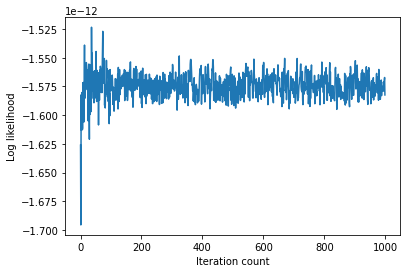

In [ ]:

plt.plot(GMM2mixturediagMusic.logLikeliHoodList)
# plt.text(2, 3, "loglikelihood", color='red', fontsize=20)
plt.xlabel("Iteration count")
plt.ylabel("Log likelihood")
# plt.title("Log likelihood versus EM iteration for 2 gaussian mixtures with diagonal covariances for music frames", pad=20)


16


Text(0, 0.5, 'Log likelihood')

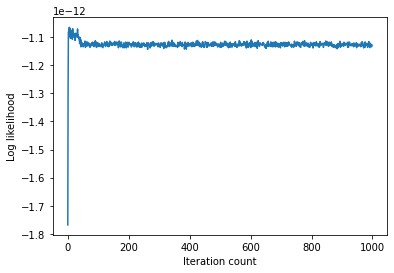

In [ ]:
GMM2mixturediagSpeech = gaussian(2)
GMM2mixturediagSpeech.gaussianfit(speechFrames)
plt.plot(GMM2mixturediagSpeech.logLikeliHoodList)
plt.xlabel("Iteration count")
plt.ylabel("Log likelihood")

28


Text(0, 0.5, 'Log_likelihood')

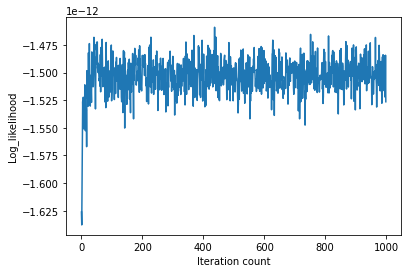

In [ ]:
GMM2mixturefullMusic= gaussian(2, covarianceFlag = False)
GMM2mixturefullMusic.gaussianfit(musicFrames)
plt.plot(GMM2mixturefullMusic.logLikeliHoodList)
plt.xlabel("Iteration count")
plt.ylabel("Log_likelihood")

15


Text(0, 0.5, 'Log_likelihood')

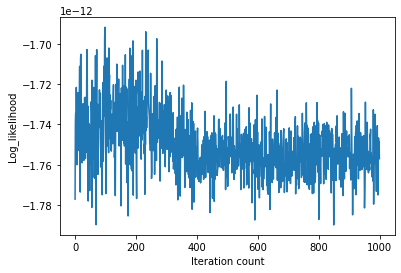

In [ ]:
GMM2mixturefullSpeech= gaussian(2, covarianceFlag = False)
GMM2mixturefullSpeech.gaussianfit(speechFrames)
plt.plot(GMM2mixturefullSpeech.logLikeliHoodList)
plt.xlabel("Iteration count")
plt.ylabel("Log_likelihood")

53


Text(0, 0.5, 'Loglikelihood')

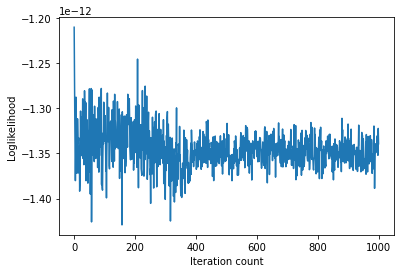

In [ ]:
GMM5mixtureDiagMusic = gaussian(numberOfMixtures = 5)
GMM5mixtureDiagMusic.gaussianfit(musicFrames)
plt.plot(GMM5mixtureDiagMusic.logLikeliHoodList)
plt.xlabel("Iteration count")
plt.ylabel("Loglikelihood")

66


Text(0, 0.5, 'Loglikelihood')

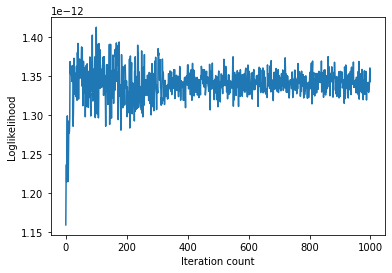

In [ ]:
GMM5mixtureDiagSpeech = gaussian(5)
GMM5mixtureDiagSpeech.gaussianfit(speechFrames)
plt.plot(-np.array(GMM5mixtureDiagSpeech.logLikeliHoodList))
plt.xlabel("Iteration count")
plt.ylabel("Loglikelihood")

76


Text(0, 0.5, 'Log_likelihood')

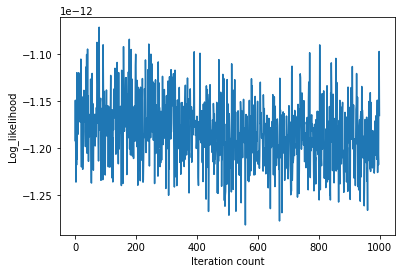

In [ ]:
GMM5mixtureFullMusic = gaussian(5, covarianceFlag = False)
GMM5mixtureFullMusic.gaussianfit(musicFrames)
plt.plot(GMM5mixtureFullMusic.logLikeliHoodList)
plt.xlabel("Iteration count")
plt.ylabel("Log_likelihood")
# plt.title("Log likelihood versus EM iteration for 5 gaussian mixtures with full covariances for music frames", pad=20)

55


Text(0.5, 1.0, 'Log likelihood versus EM iteration for 5 gaussian mixtures with full covariances for speech frames')

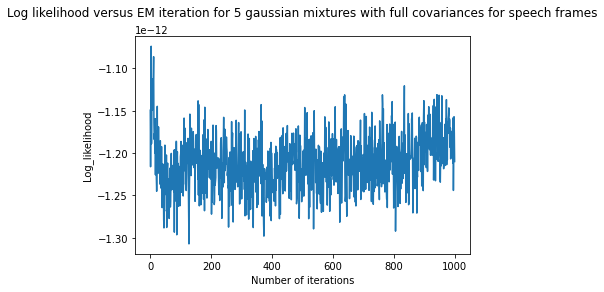

In [ ]:
GMM5mixtureFullSpeech= gaussian(5, covarianceFlag = False)
GMM5mixtureFullSpeech.gaussianfit(speechFrames)
plt.plot(GMM5mixtureFullSpeech.logLikeliHoodList)
plt.xlabel("Number of iterations")
plt.ylabel("Log_likelihood")
plt.title("Log likelihood versus EM iteration for 5 gaussian mixtures with full covariances for speech frames", pad=20)

In [ ]:
#Testing
path = 'drive/MyDrive/Data/speech_music_classification/test/'
test = []

files = glob.glob(path + '*.wav')

for i in files:
    if(i.split('/')[-1].split('_')[0] == 'music'):
      test.append(0)
    else:
      test.append(1)
print(test)

prediction = []
for i in files:
    testData, sampleRate = librosa.load(i, sr=None)
    testDataSpectogram = spectrogramFeatureGeneration(testData)

    TestSpeechLogLikelihood = GMM5mixtureDiagSpeech.logLikelihood(testDataSpectogram)
    TestMusicLogLikelihood = GMM5mixtureDiagSpeech.logLikelihood(testDataSpectogram)
    if(TestMusicLogLikelihood > TestSpeechLogLikelihood):
      prediction.append(0)
    else:
      prediction.append(1)
test = np.array(test)
prediction = np.array(prediction)

count = 0
for i in range(0, len(test)):
  if(prediction[i] == test[i]):
    count += 1
print("Accuracy : ", (count/len(files)*100))